In [1]:
# This code mostly reproduces Elsa Arcaute's R practical for igraph in Python.

In [89]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

% matplotlib inline
nx.__version__

'2.1'

# Data Preparation

In [2]:
# Open the shapefile using geopandas
tube_shp = gpd.read_file(r'underground/underground.shp')

In [3]:
tube_shp.head()

,toid_seq,station_1,station_1_,station_2,station_2_,distance,geometry
0,1,11,Baker Street,163,Marylebone,416.586050,"LINESTRING (-0.1571 51.5226, -0.1631 51.5225)"
1,2,11,Baker Street,212,Regent's Park,734.173636,"LINESTRING (-0.1571 51.5226, -0.1466 51.5234)"
2,3,49,Charing Cross,87,Embankment,179.503418,"LINESTRING (-0.1247 51.508, -0.1223 51.5074)"
3,4,49,Charing Cross,197,Picadilly Circus,689.289845,"LINESTRING (-0.1247 51.508, -0.1342 51.5098)"
4,5,82,Edgware Road (B),163,Marylebone,441.218104,"LINESTRING (-0.1679 51.5199, -0.1631 51.5225)"


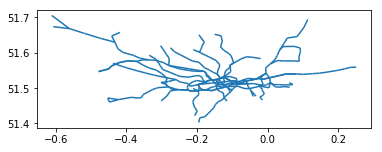

In [4]:
# Immediately we can derive a plot of the shapefile.
# However, this representation doesn't currently include any actual network information
# It's just a drawing of lines on a chart!
tube_shp.plot()

In [5]:
# Here are a few descriptive queries, following Elsa's example

# What is the maximum distance between stations?
tube_shp['distance'].max()

7115.1482774610004

In [6]:
# Which are the stations that are furthest apart?
tube_shp[tube_shp['distance'] == tube_shp['distance'].max()]

,toid_seq,station_1,station_1_,station_2,station_2_,distance,geometry
239,240,94,Finchley Road,282,Wembley Park,7115.148277,"LINESTRING (-0.1803 51.5472, -0.2795 51.5635)"


In [7]:
# Some pairs of stations appear multiple times, why?
# e.g. node 11 - due to the different lines that pass through the station.
tube_shp[tube_shp['station_1'] == 11]

,toid_seq,station_1,station_1_,station_2,station_2_,distance,geometry
0,1,11,Baker Street,163,Marylebone,416.586050,"LINESTRING (-0.1571 51.5226, -0.1631 51.5225)"
1,2,11,Baker Street,212,Regent's Park,734.173636,"LINESTRING (-0.1571 51.5226, -0.1466 51.5234)"
75,76,11,Baker Street,83,Edgware Road (C),931.211577,"LINESTRING (-0.1571 51.5226, -0.17 51.5203)"
76,77,11,Baker Street,104,Great Portland Street,925.826411,"LINESTRING (-0.1571 51.5226, -0.1439 51.5238)"
170,171,11,Baker Street,83,Edgware Road (C),931.211577,"LINESTRING (-0.1571 51.5226, -0.17 51.5203)"
171,172,11,Baker Street,104,Great Portland Street,925.826411,"LINESTRING (-0.1571 51.5226, -0.1439 51.5238)"
196,197,11,Baker Street,28,Bond Street,1076.607648,"LINESTRING (-0.1571 51.5226, -0.1494 51.5142)"
197,198,11,Baker Street,249,St. John's Wood,1785.442777,"LINESTRING (-0.1571 51.5226, -0.174 51.5347)"
224,225,11,Baker Street,104,Great Portland Street,925.826411,"LINESTRING (-0.1571 51.5226, -0.1439 51.5238)"
225,226,11,Baker Street,94,Finchley Road,3175.274183,"LINESTRING (-0.1571 51.5226, -0.1803 51.5472)"


In [8]:
# We can also select the same information by station name:
tube_shp[tube_shp['station_1_'] == 'Baker Street']

,toid_seq,station_1,station_1_,station_2,station_2_,distance,geometry
0,1,11,Baker Street,163,Marylebone,416.586050,"LINESTRING (-0.1571 51.5226, -0.1631 51.5225)"
1,2,11,Baker Street,212,Regent's Park,734.173636,"LINESTRING (-0.1571 51.5226, -0.1466 51.5234)"
75,76,11,Baker Street,83,Edgware Road (C),931.211577,"LINESTRING (-0.1571 51.5226, -0.17 51.5203)"
76,77,11,Baker Street,104,Great Portland Street,925.826411,"LINESTRING (-0.1571 51.5226, -0.1439 51.5238)"
170,171,11,Baker Street,83,Edgware Road (C),931.211577,"LINESTRING (-0.1571 51.5226, -0.17 51.5203)"
171,172,11,Baker Street,104,Great Portland Street,925.826411,"LINESTRING (-0.1571 51.5226, -0.1439 51.5238)"
196,197,11,Baker Street,28,Bond Street,1076.607648,"LINESTRING (-0.1571 51.5226, -0.1494 51.5142)"
197,198,11,Baker Street,249,St. John's Wood,1785.442777,"LINESTRING (-0.1571 51.5226, -0.174 51.5347)"
224,225,11,Baker Street,104,Great Portland Street,925.826411,"LINESTRING (-0.1571 51.5226, -0.1439 51.5238)"
225,226,11,Baker Street,94,Finchley Road,3175.274183,"LINESTRING (-0.1571 51.5226, -0.1803 51.5472)"


In [9]:
# If you are worried about not getting all instances, due to issues with spaces etc. use regular expressions
# pandas does this nicely with string functions.
# NB the ^ means that the pattern 'Baker' must occur at the beginning of the text e.g. 'Baker Street' not 'West baker Street'.
tube_shp[tube_shp['station_1_'].str.contains(r'^Baker')]

,toid_seq,station_1,station_1_,station_2,station_2_,distance,geometry
0,1,11,Baker Street,163,Marylebone,416.586050,"LINESTRING (-0.1571 51.5226, -0.1631 51.5225)"
1,2,11,Baker Street,212,Regent's Park,734.173636,"LINESTRING (-0.1571 51.5226, -0.1466 51.5234)"
75,76,11,Baker Street,83,Edgware Road (C),931.211577,"LINESTRING (-0.1571 51.5226, -0.17 51.5203)"
76,77,11,Baker Street,104,Great Portland Street,925.826411,"LINESTRING (-0.1571 51.5226, -0.1439 51.5238)"
170,171,11,Baker Street,83,Edgware Road (C),931.211577,"LINESTRING (-0.1571 51.5226, -0.17 51.5203)"
171,172,11,Baker Street,104,Great Portland Street,925.826411,"LINESTRING (-0.1571 51.5226, -0.1439 51.5238)"
196,197,11,Baker Street,28,Bond Street,1076.607648,"LINESTRING (-0.1571 51.5226, -0.1494 51.5142)"
197,198,11,Baker Street,249,St. John's Wood,1785.442777,"LINESTRING (-0.1571 51.5226, -0.174 51.5347)"
224,225,11,Baker Street,104,Great Portland Street,925.826411,"LINESTRING (-0.1571 51.5226, -0.1439 51.5238)"
225,226,11,Baker Street,94,Finchley Road,3175.274183,"LINESTRING (-0.1571 51.5226, -0.1803 51.5472)"


In [10]:
# Now we want to extract the actual station locations from these data.
# We'd like the id and name of each station, and the starting point of the line representing the connection.
# Here's an approximation of the way it's done in the R code, which uses tidy() from broom.

# First we need to get the start and end lons and lats from the line geometry
tube_shp['start_lon'] = tube_shp.geometry.apply(lambda x: x.coords[0][0])
tube_shp['start_lat'] = tube_shp.geometry.apply(lambda x: x.coords[0][1])
tube_shp['end_lon'] = tube_shp.geometry.apply(lambda x: x.coords[1][0])
tube_shp['end_lat'] = tube_shp.geometry.apply(lambda x: x.coords[1][1])

# Now we'll create a new pandas dataframe with just the first stations
firstStation = tube_shp[['station_1','station_1_','start_lon','start_lat']].copy()
# Rename the columns to align with the R example
firstStation.rename(columns = {'station_1':'id','station_1_':'name','start_lon':'long','start_lat':'lat'} ,inplace = True)

# And again for the second stations
secondStation = tube_shp[['station_2','station_2_','end_lon','end_lat']].copy()
# Rename the columns to align with the R example
secondStation.rename(columns = {'station_2':'id','station_2_':'name','end_lon':'long','end_lat':'lat'} ,inplace = True)

# Now append the two dataframes
stations = firstStation.append(secondStation)

# Finally remove the duplicate stations by their id - there are 306 unique stations.
stations.drop_duplicates('id', inplace= True)

# We need these stations and coordinates so that we can locate the stations in space when we create a network graph

In [11]:
# I don't like working in a geographic coordinate system that much.
#Let's also create a version of stations using the British National Grid.
from shapely.geometry import Point
stations_BNG = gpd.GeoDataFrame(stations, geometry = stations.apply(lambda x: Point(x['long'],x['lat']) , axis=1).values)
# Set original crs as WGS84
stations_BNG.crs = {'init':'epsg:4326'}
# Now project to BNG
stations_BNG = stations_BNG.to_crs({'init':'epsg:27700'})
# Finally extract points to columns
stations_BNG['X'] = stations_BNG['geometry'].x
stations_BNG['Y'] = stations_BNG['geometry'].y

# Networkx

In [12]:
# Now lets construct the network
# NB have to use a multigraph here to preserve all of the edges - e.g. where circle and district are the same etc.
g_tube = nx.from_pandas_edgelist(tube_shp,'station_1','station_2',edge_attr = 'distance', create_using=nx.MultiGraph())

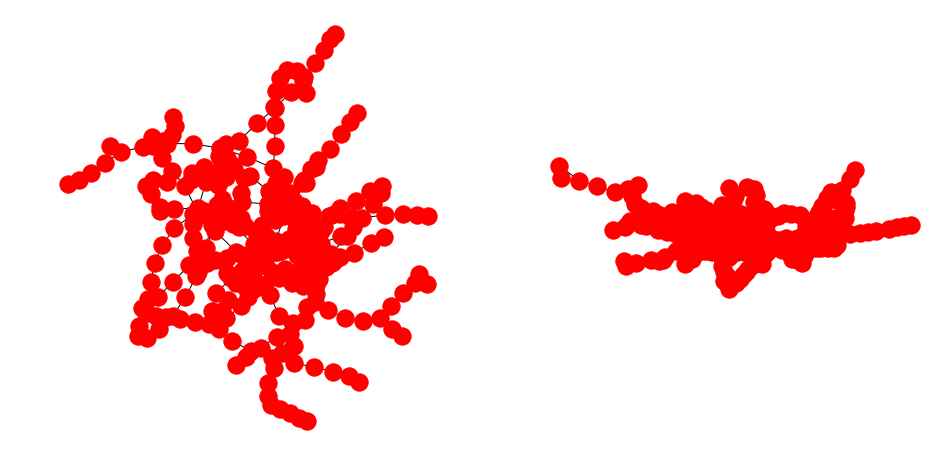

In [13]:
# A quick plot
f, (ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# Draw the tube network using the defaults - a spring layout, I think.
nx.draw(g_tube,ax=ax1)

# convert the stations info to a dictionary of positions
pos = stations[['id','long','lat']].set_index('id').T.to_dict('list')

# Draw while assigning spatial locations to the points
# Now it looks like the original shapefile plot!
nx.draw(g_tube,pos=pos, ax = ax2)
ax2.set_aspect('equal')

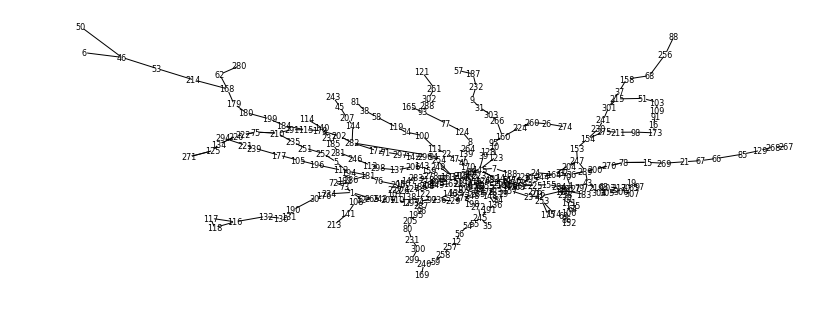

In [14]:
# I can't really see anything, so let's improve the visualisation of the spatially embedded network
# Still not great, but much improved!
f, ax = plt.subplots(figsize=(14,8))
nx.draw(g_tube,pos=pos, ax = ax, node_size = 20, node_color = 'w', with_labels=True, font_size = 8)
ax.set_aspect('equal')

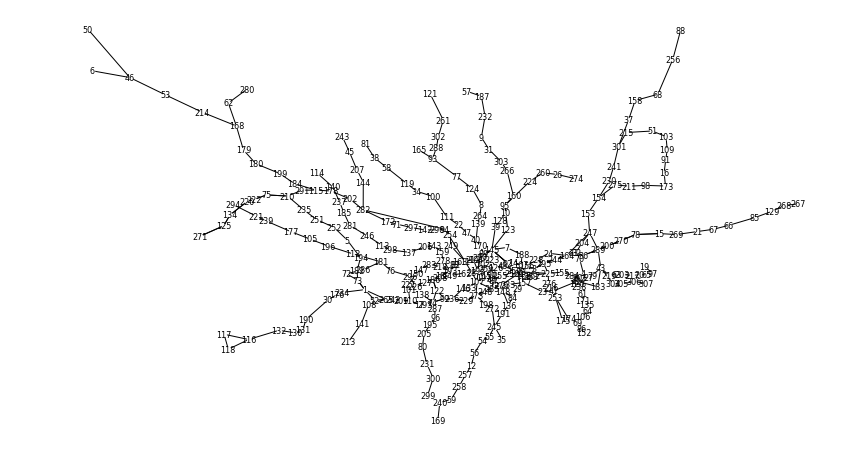

In [15]:
# Let's try drawing the graph, but using projected coordinates
# convert the stations_bng info to a dictionary of positions
pos_bng = stations_BNG[['id','X','Y']].set_index('id').T.to_dict('list')
f, ax = plt.subplots(figsize=(14,8))
nx.draw(g_tube,pos=pos_bng, ax = ax, node_size = 20, node_color = 'w', with_labels=True, font_size = 8)
ax.set_aspect('equal')

In [16]:
# Anyway, let's look at some properties of the graph

# Number of stations
g_tube.number_of_nodes()

306

In [17]:
# Number of edges
g_tube.number_of_edges()

410

In [18]:
# Number of islands or disconnected components
nx.number_connected_components(g_tube)

1

In [19]:
# Unweighted diameter (topological diameter)
nx.diameter(g_tube)

38

In [20]:
# Weighted diameter, using eccentricity and dictionary of shortest paths
e = nx.eccentricity(g_tube, sp = dict(nx.shortest_path_length(g_tube,weight='distance')))
nx.diameter(g_tube,e)

71491.11880904001

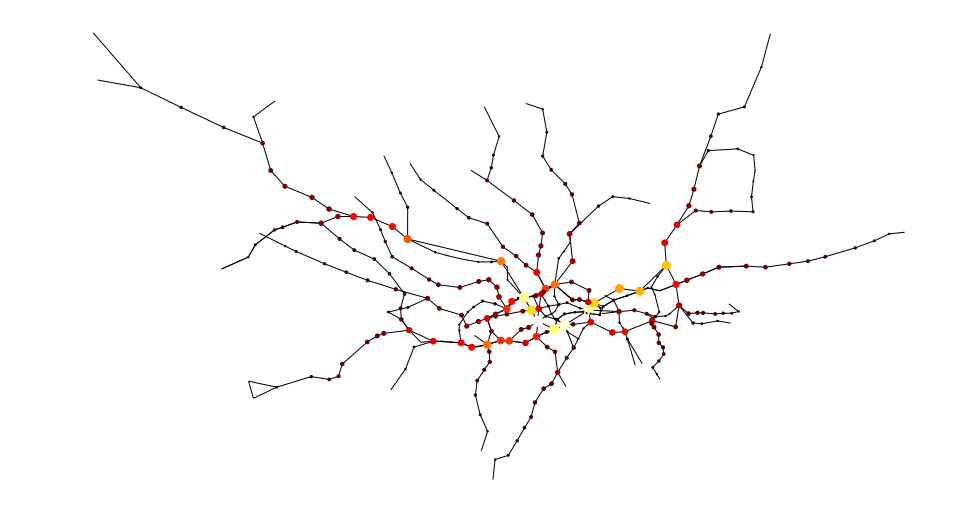

In [33]:
# Compute betweenness - for multigraphs networkx only computes the topological betweenness.
# This happens even if the weight parameter is set.
# returns a dictionary
bet_tube = nx.betweenness_centrality(g_tube)

# make bet_london a pandas dataframe for ease
bet_tube = pd.DataFrame.from_dict(bet_tube, orient='index')

f, ax = plt.subplots(figsize=(16,10))
nx.draw(g_tube,pos=pos_bng, ax = ax, node_size = bet_tube/bet_tube.max()*100, cmap = 'hot', node_color = bet_tube[0])
ax.set_aspect('equal')

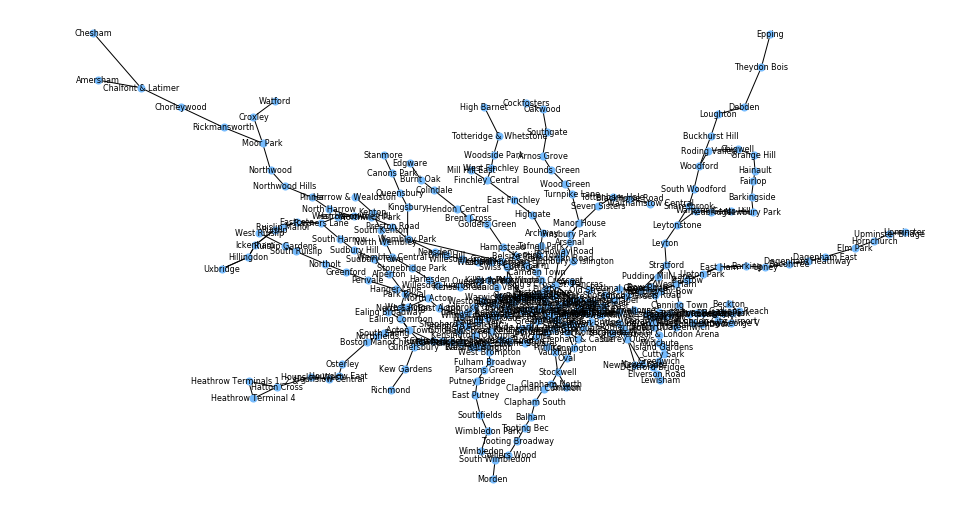

In [58]:
# Now let's add the names of the stations to the graph
name_dict = stations[['id','name']].set_index('id').to_dict()['name']
# To add names, do this, but it's not strictly necessary for labelling.
nx.set_node_attributes(g_tube, name_dict, 'name')

# Now plot with labels
f, ax = plt.subplots(figsize=(16,10))
nx.draw(g_tube, pos=pos_bng, ax = ax, node_size = 50, node_color = 'xkcd:sky blue', with_labels=True, labels= name_dict, font_size = 8)
ax.set_aspect('equal')

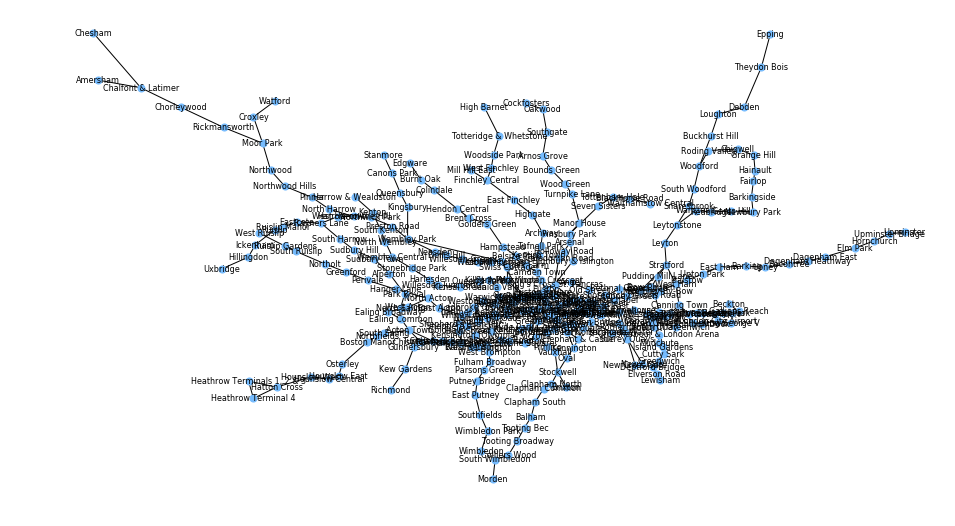

In [61]:
# Currently, our multigraph has are several pairs stations connected by multiple lines.
# We can simplify the Graph to remove duplicate edges.
g_london = nx.Graph()
for u,v,data in g_tube.edges(data=True):
    w = data['distance']
    if g_london.has_edge(u,v):
        # If edge exists use the smallest distance as the weight
        if w < g_london[u][v]['distance']:
            g_london[u][v]['distance'] = w
    else:
        g_london.add_edge(u, v, distance=w)

# Add node names back in for earlier name dictionary
nx.set_node_attributes(g_london, name_dict, 'name')
        
# NB g_london = nx.Graph(g_tube) also works, but you can't change way edge data are assigned.
# This means that the weights etc. will simply be the ones that are seen first.

# Now plot with labels
f, ax = plt.subplots(figsize=(16,10))
nx.draw(g_london, pos=pos_bng, ax = ax, node_size = 50, node_color = 'xkcd:sky blue', with_labels=True, labels= name_dict, font_size = 8)
ax.set_aspect('equal')

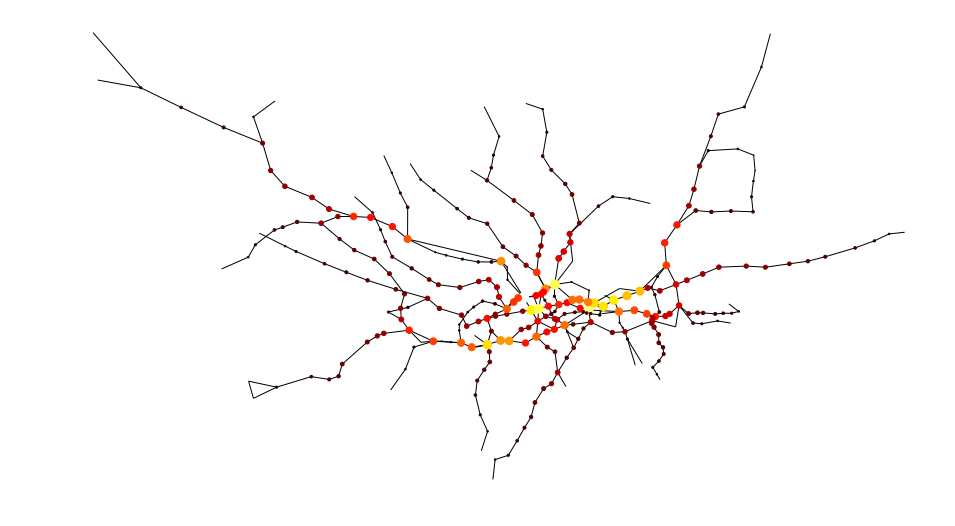

In [26]:
# If we want to calculate weighted betweenness, specify weight, the default is none.
# Adding distances may change shortest paths compared to the topological case where each edge is of value 1.
#Compute betweenness - returns a dictionary
bet_london = nx.betweenness_centrality(g_london, weight = 'distance')

# make bet_london a pandas dataframe for ease
bet_london = pd.DataFrame.from_dict(bet_london, orient='index')

f, ax = plt.subplots(figsize=(16,10))
nx.draw(g_london,pos=pos_bng, ax = ax, node_size = bet_london/bet_london.max()*100, cmap = 'hot', node_color = bet_london[0])
ax.set_aspect('equal')

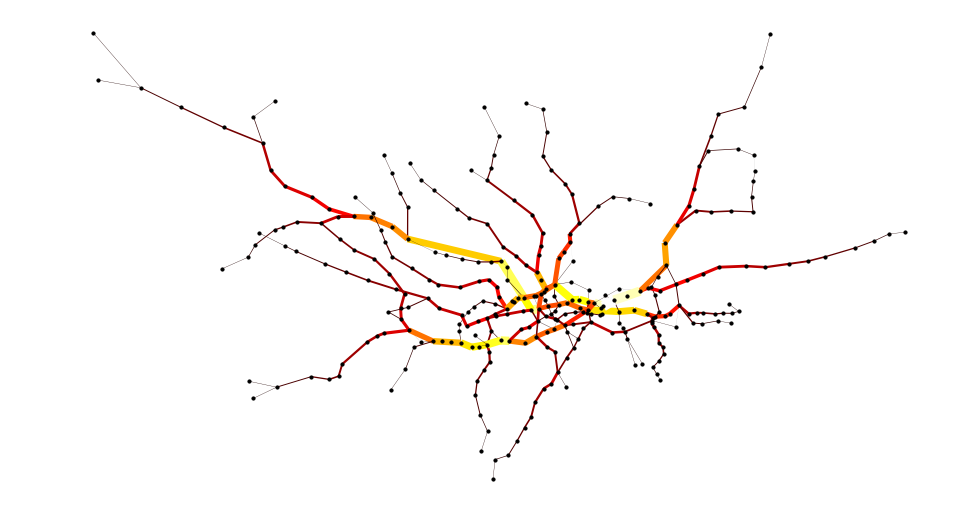

In [31]:
# edge betweenness - with edge weights as distance.
ebet_lon = nx.edge_betweenness_centrality(g_london, weight='distance')

f, ax = plt.subplots(figsize=(16,10))
nx.draw(g_london,pos=pos_bng, ax = ax, node_size = 10, node_color = 'k', edgelist = ebet_lon.keys(), 
        edge_color = ebet_lon.values(),edge_cmap = plt.cm.hot, width = np.array(ebet_lon.values())/max(ebet_lon.values())*10)
ax.set_aspect('equal')

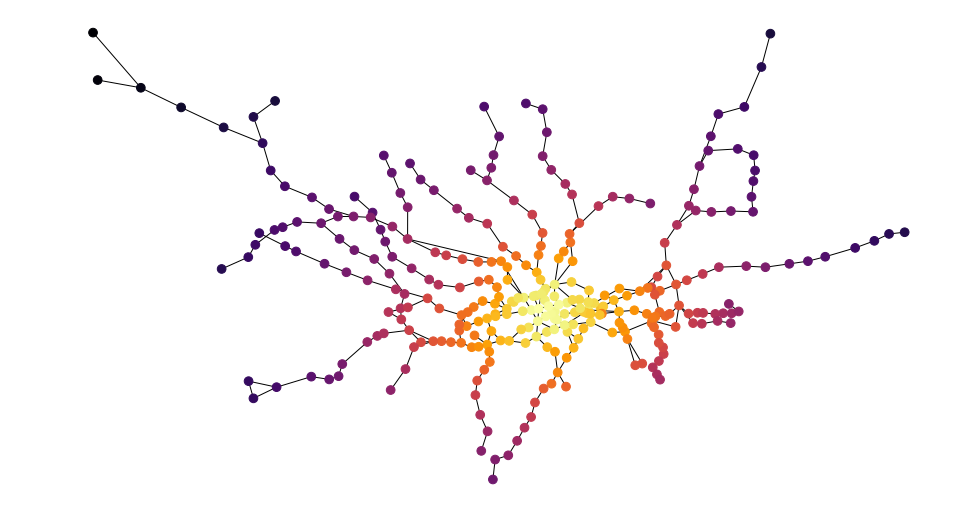

In [54]:
#closeness, with distance specified for shortest paths. Automatically normalised.
clos_london = nx.closeness_centrality(g_london, distance = 'distance')

# make clos_london a pandas dataframe for ease of use
clos_london = pd.DataFrame.from_dict(clos_london, orient='index')

# Plot the centrality on the graph
f, ax = plt.subplots(figsize=(16,10))
nx.draw(g_london,pos=pos_bng, ax = ax, node_size = 75, cmap = 'inferno', node_color = clos_london[0])
ax.set_aspect('equal')

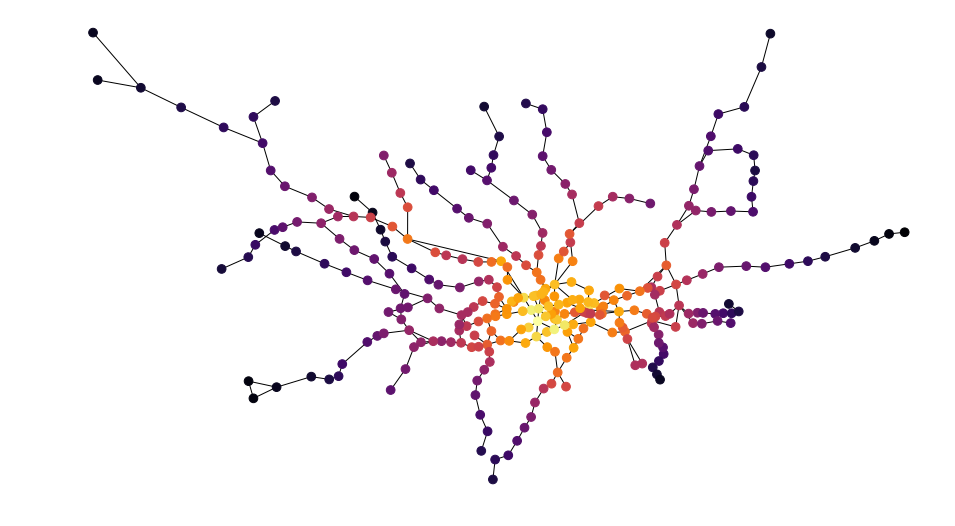

In [55]:
# Topological closeness. Automatically normalised.
clos_london = nx.closeness_centrality(g_london)

# make clos_london a pandas dataframe for ease of use
clos_london = pd.DataFrame.from_dict(clos_london, orient='index')

# Plot the centrality on the graph
f, ax = plt.subplots(figsize=(16,10))
nx.draw(g_london,pos=pos_bng, ax = ax, node_size = 75, cmap = 'inferno', node_color = clos_london[0])
ax.set_aspect('equal')

In [ ]:
# Exercise:
 
# 1) Remove nodes according to a selected property: e.g. degree, closeness centrality and betweenness centrality

# 2) think about the effects on the network of removing such nodes. Which have more impact on the network?

In [88]:
# to remove nodes, first identify nodes by 'name' to get their ids.
del_nodes = filter(lambda (n, d): d['name'] in ['Baker Street','Embankment'], g_london.nodes(data=True))

# NB removal is in place
g_london_1 = deepcopy(g_london)
g_london_1.remove_nodes_from([x[0] for x in del_nodes])

g_london.number_of_nodes()

304

# igraph

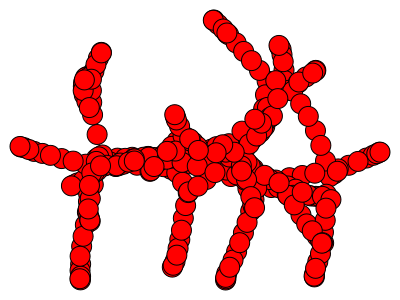

In [154]:
g_tube = ig.Graph(directed = False)

# The stations represent the possible nodes
# I have to cast the ids as strings as otherwise they get assigned as node ids, which have to start from 0.
g_tube.add_vertices(stations['id'].values.astype(str))

# Now take the edge list and add edges. Agin as string to match names.
g_tube.add_edges(tube_shp[['station_1','station_2']].values.astype('str'))

# Finally add edge weights
g_tube.es['weight'] = tube_shp['distance'].values

# Now, a basic plot
ig.plot(g_tube, layout = g_tube.layout_drl(),bbox =(400,300))

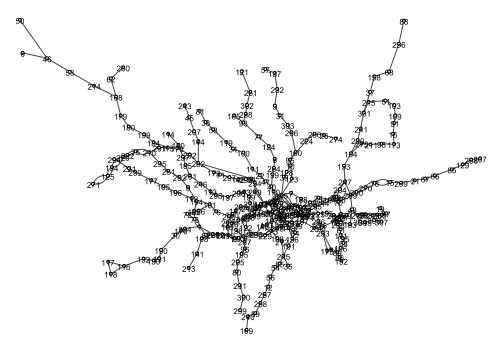

In [221]:
# Let's add in some geographic locations for this plot and tidy up the nodes
# NB Have to multiply y-axis coordinates by -1 as Cairo plots from top left, not bottom left. 

#pos = ig.Layout(stations[['long','lat']].apply(lambda x: (x['long'],x['lat']*-1.0),axis=1).tolist())
pos = ig.Layout(stations_BNG[['X','Y']].apply(lambda x: (x['X'],x['Y']*-1.0),axis=1).tolist())

# Set 'label' to vertex 'name'
g_tube.vs['label'] = g_tube.vs['name']

# This looks a bit better!
ig.plot(g_tube, layout = pos, vertex_size = 3, vertex_color = 'white', vertex_label_size = 8, bbox =(500,350))

In [193]:
# Anyway, let's look at some properties of the graph

# Number of stations
len(g_tube.vs())

306

In [194]:
# Number of edges
len(g_tube.es())

410

In [208]:
# Number of islands or disconnected components
len(g_tube.clusters().subgraphs())

1

In [210]:
# Diameter accounting for edge weights
g_tube.diameter(weights='weight')

71491.11880904001

In [211]:
# Unweighted or 'topological' diameter
g_tube.diameter()

38

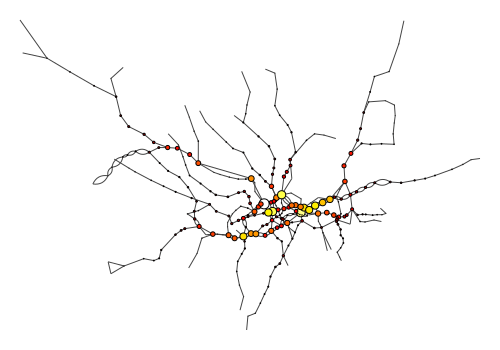

In [263]:
#Compute betweenness
bet_london = g_tube.betweenness(directed = False, weights = 'weight')

# Remove labelling for now.
del g_tube.vs['label']

# I'm going to use matplotlib to work out my colours for me!
# First normalize the data
norm = (np.array(bet_london) - min(bet_london)) / (max(bet_london) - min(bet_london))
# Now get a colourmap
cmap = plt.cm.get_cmap('hot')
# Now get rgb values, but throw away opacity, and map to a list of tuples
palette = map(tuple,cmap(norm)[:,0:3])

ig.plot(g_tube, layout = pos, vertex_size = np.array(bet_london)/max(bet_london) * 10, vertex_color = palette, bbox =(500,350))

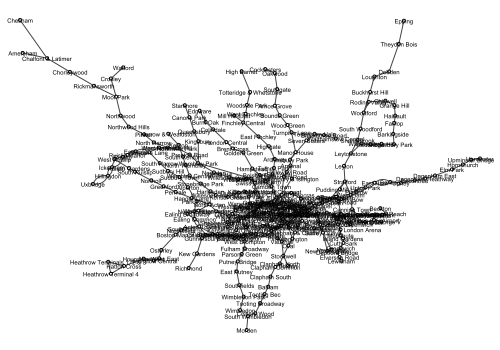

In [275]:
# Add the station names to the vertices
g_tube.vs['station'] = stations['name'].values.astype('S')

# Set 'label' to vertex 'station'
g_tube.vs['label'] = g_tube.vs['station']

# Plot with labels
ig.plot(g_tube, layout = pos, vertex_size = 3, vertex_color = 'white', vertex_label_size = 6, bbox =(500,350))

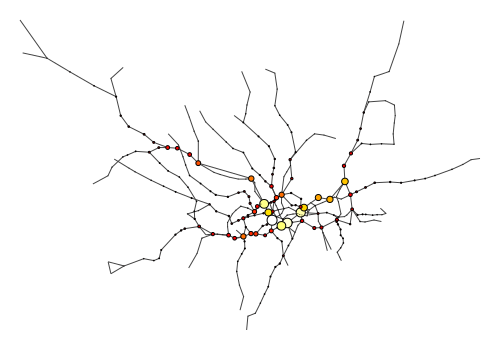

In [284]:
# When there are many lines connecting pairs, we get multiple entries.
# We can simplify the network as follows:
g_london = g_tube.simplify(loops = True, multiple = True, combine_edges= 'min')

# Now compute topological betweenness (i.e. unweighted)
bet_london = g_tube.betweenness(directed = False, weights = None)

# Remove labelling for now.
del g_tube.vs['label']

# I'm going to use matplotlib to work out my colours for me!
# First normalize the data
norm = (np.array(bet_london) - min(bet_london)) / (max(bet_london) - min(bet_london))
# Now get a colourmap
cmap = plt.cm.get_cmap('hot')
# Now get rgb values, but throw away opacity, and map to a list of tuples
palette = map(tuple,cmap(norm)[:,0:3])

ig.plot(g_tube, layout = pos, vertex_size = np.array(bet_london)/max(bet_london) * 10, vertex_color = palette, bbox =(500,350))

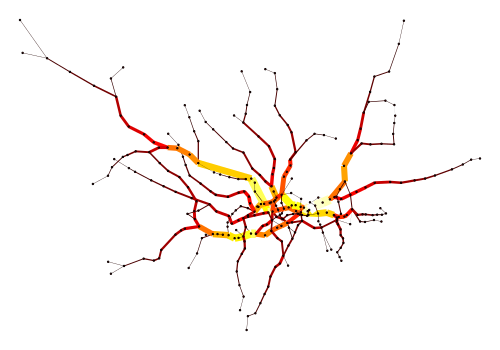

In [293]:
# Edge betweenness with weights
edge_bet_london = g_london.edge_betweenness(weights='weight')

# Normalize the data
norm = (np.array(edge_bet_london) - min(edge_bet_london)) / (max(edge_bet_london) - min(edge_bet_london))
# Now get a colourmap
cmap = plt.cm.get_cmap('hot')
# Now get rgb values, but throw away opacity, and map to a list of tuples
palette = map(tuple,cmap(norm)[:,0:3])

ig.plot(g_tube, layout = pos, edge_width = np.array(edge_bet_london)/max(edge_bet_london) * 10, edge_color = palette, 
        vertex_size = 1.5,  bbox =(500,350))


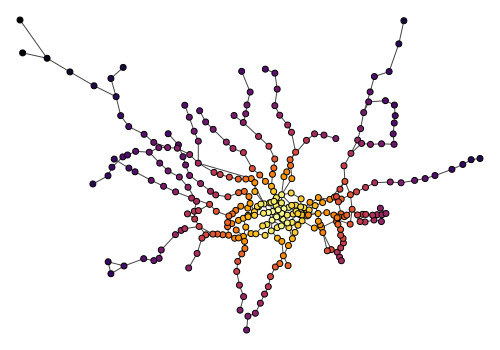

In [316]:
# closeness
clos_london = g_london.closeness(weights= 'weight')

# First normalize the data 0-1
norm = (np.array(clos_london) - min(clos_london)) / (max(clos_london) - min(clos_london))
# Now get a colourmap
cmap = plt.cm.get_cmap('inferno')
# Now get rgb values, but throw away opacity, and map to a list of tuples
palette = map(tuple,cmap(norm)[:,0:3])

ig.plot(g_tube, layout = pos, vertex_size = 6, vertex_color = palette, bbox =(500,350))

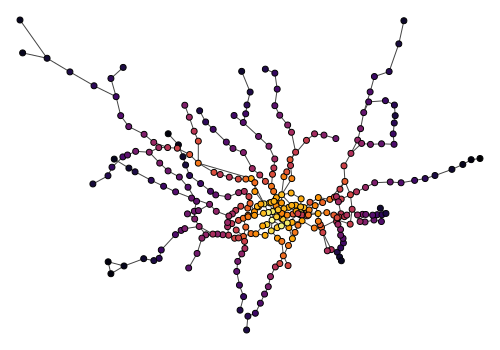

In [315]:
# topological closeness
clos_london = g_london.closeness(weights= None)

# First normalize the data 0-1
norm = (np.array(clos_london) - min(clos_london)) / (max(clos_london) - min(clos_london))
# Now get a colourmap
cmap = plt.cm.get_cmap('inferno')
# Now get rgb values, but throw away opacity, and map to a list of tuples
palette = map(tuple,cmap(norm)[:,0:3])

ig.plot(g_tube, layout = pos, vertex_size = 6, vertex_color = palette, bbox =(500,350))

In [314]:
# Exercise:
#   
# 1) Remove nodes according to a selected property: e.g. degree, closeness centrality and betweenness centrality
# 
# 2) think about the effects on the network of removing such nodes. Which have more impact on the network?

In [331]:
# to remove nodes
g_london_1 = ig.deepcopy(g_london)
# Get node indices
del_nodes = [v.index for v in g_london_1.vs if v['station'] in ["Baker Street","Embankment"]]
# Delete nodes
g_london_1.delete_vertices(del_nodes)

len(g_london_1.vs())

304